# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


## Step 0: Load The Data

In [1]:
# import everything we'll need

import pickle
import csv
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import os
from PIL import Image


In [2]:
# load pickled data

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_raw, y_train_raw = train['features'], train['labels']
X_valid_raw, y_valid_raw = valid['features'], valid['labels']
X_test_raw, y_test_raw = test['features'], test['labels']

print("Data loaded.")


Data loaded.


## Step 1: Dataset Summary & Exploration

In [3]:
# summarize the data

n_train = len(X_train_raw)
n_valid = len(X_valid_raw)
n_test = len(X_test_raw)
image_shape = X_train_raw[0].shape
n_classes = len(set(y_train_raw))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


Sign 40: "Roundabout mandatory"


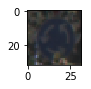

In [4]:
# data exploration

%matplotlib inline

# show a random image and its name
sign_names_file = 'signnames.csv'
sign_names = {}
with open(sign_names_file,'r') as f:
    datareader = csv.reader(f)
    header = next(datareader)
    for row in datareader:
        sign_names[int(row[0])] = row[1]

index = random.randint(0, len(X_train_raw))
image = X_train_raw[index]
plt.figure(figsize=(1,1))
plt.imshow(image)
sign_index = y_train_raw[index]
print("Sign {0}: \"{1}\"".format(sign_index,sign_names[sign_index]))


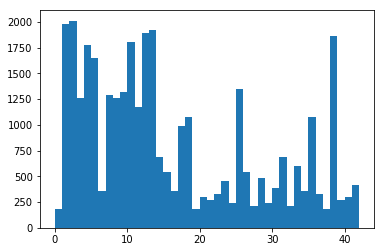

Most represented sign: Speed limit (50km/h)
Least represented sign: Speed limit (20km/h)


In [5]:
# further data exploration

# histogram of number of sign types in training data
# shows that we don't have very balanced data - many more signs of some types!
plt.hist(y_train_raw,range(43))
plt.show()

# determine which signs are most/least represented in training data
unique, counts = np.unique(y_train_raw,return_counts=True)
count_dict = dict(zip(unique,counts)) 
max_sign = max(count_dict.keys(), key = (lambda key: count_dict[key]))
min_sign = min(count_dict.keys(), key = (lambda key: count_dict[key]))    
print('Most represented sign: {0}'.format(sign_names[max_sign]))
print('Least represented sign: {0}'.format(sign_names[min_sign]))


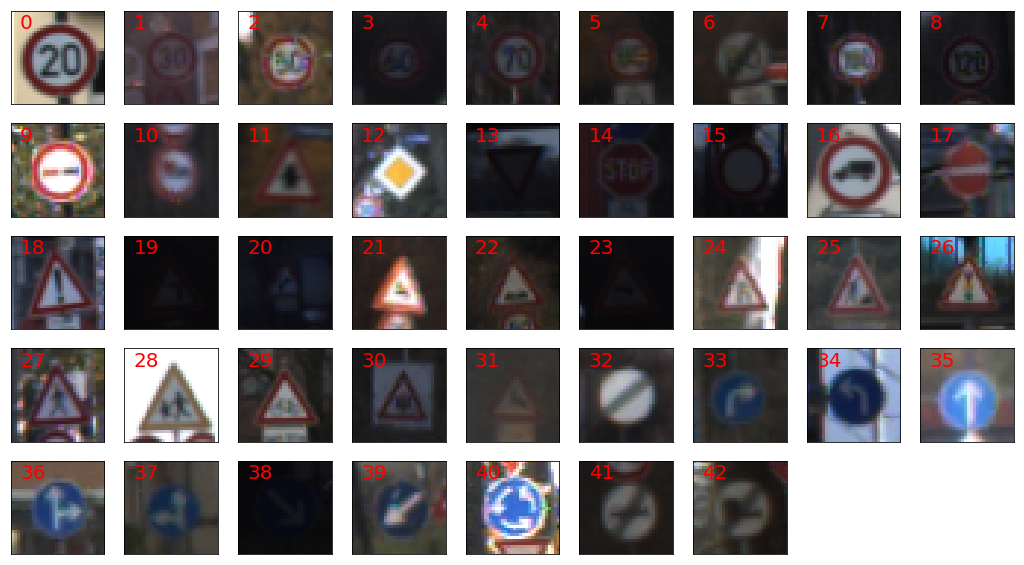

In [6]:
# further data exploration
# print an image of each class of sign

n_width = 5
n_height = 9

f = plt.figure(figsize=(2*n_height,2*n_width))

for i in range(n_classes):
    ax = f.add_subplot(n_width,n_height,i+1)
    sign_index = np.where(y_train_raw==i)[0][0]
    ax.imshow(X_train_raw[sign_index])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.1,0.8,"{0}".format(i),color='r',fontsize=20,transform=ax.transAxes)
    
plt.show()


## Step 2: Design and Test a Model Architecture

In [7]:
# pre-process data

# v0: no pre-processing

"""
num_channels = 3

X_train = X_train_raw
X_test = X_test_raw
X_valid = X_valid_raw

y_train = y_train_raw
y_test = y_test_raw
y_valid = y_valid_raw
"""

# v1: normalize (keep RGB color)

"""
num_channels = 3

X_train = (X_train_raw.astype(np.float32) - 128.0) / 128.0
X_test = (X_test_raw.astype(np.float32) - 128.0) / 128.0
X_valid = (X_valid_raw.astype(np.float32) - 128.0) / 128.0

y_train = y_train_raw
y_test = y_test_raw
y_valid = y_valid_raw
"""

# v2: grayscale and normalize
# shape needs to be (number of observations,32,32,1) to match tf.nn.conv2d later
# thanks to https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

"""
num_channels = 1

rgb2gray_weights = [0.299,0.587,0.114]

X_train = np.zeros((len(y_train),32,32,1),dtype=np.float32)
X_test = np.zeros((len(y_test),32,32,1),dtype=np.float32)
X_valid = np.zeros((len(y_valid),32,32,1),dtype=np.float32)

for i in range(len(y_train)):
    X_train[i,:,:,0] = (np.dot(X_train_raw[i],rgb2gray_weights) - 128.0) / 128.0
    
for i in range(len(y_valid)):
    X_valid[i,:,:,0] = (np.dot(X_valid_raw[i],rgb2gray_weights) - 128.0) / 128.0

for i in range(len(y_test)):
    X_test[i,:,:,0] = (np.dot(X_test_raw[i],rgb2gray_weights) - 128.0) / 128.0

y_train = y_train_raw
y_test = y_test_raw
y_valid = y_valid_raw
"""

# v3: normalize RGB images based on each image max/min

num_channels = 3

def im_specific_normalize(X):
    
    X_new = np.zeros((len(X),32,32,3),dtype=np.float32)
        
    for i in range(len(X)):
        for channel in [0,1,2]:
            channel_max = float(X[i,:,:,channel].max())
            channel_min = float(X[i,:,:,channel].min())
            mu = (channel_max + channel_min) / 2
            sigma = channel_max - mu
            if mu == 0 or sigma == 0:
                X_new[i,:,:,channel] = 0.0
                print("Warning: Zero-contrast image.") 
            else:
                X_new[i,:,:,channel] = ( X[i,:,:,channel] - mu ) / sigma
    
    return X_new
            
X_train = im_specific_normalize(X_train_raw)
X_valid = im_specific_normalize(X_valid_raw)
X_test = im_specific_normalize(X_test_raw)

y_train = y_train_raw
y_test = y_test_raw
y_valid = y_valid_raw

print('finished')


finished


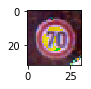

In [8]:
# re-check the data after normalization

index = random.randint(0, len(X_train))
plt.figure(figsize=(1,1))

if num_channels == 1:    # grayscale
    image = X_train[index,:,:,0]
    plt.imshow(image,cmap='gray')    
else:                    # color
    image = X_train[index]
    plt.imshow(image)


### Model Architecture

In [9]:
# define network architecture

def myNet(x,keep_prob):
    
    mu = 0
    sigma = 0.1
    
    # conv layer 1: 32x32x[num_channels] -> 28x28x6
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5,5,num_channels,6),mean=mu,stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x,conv1_w,strides=[1,1,1,1],padding='VALID') + conv1_b
    conv1   = tf.nn.relu(conv1)
    
    # maxpool layer 1: 28x28x6 -> 14x14x6
    conv1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    # conv layer 2: 14x14x6 -> 10x10x16
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5,5,6,16),mean=mu,stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1,conv2_w,strides=[1,1,1,1],padding='VALID') + conv2_b
    conv2   = tf.nn.relu(conv2)
    
    # maxpool layer2: 10x10x16 -> 5x5x16
    conv2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    # flatten: 5x5x16 -> 400
    flat1 = tf.contrib.layers.flatten(conv2)
    
    # fully connected layer 1: 400 -> 120
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400,120),mean=mu,stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(flat1,fc1_w) + fc1_b
    fc1   = tf.nn.relu(fc1)
    
    # dropout layer 1
    fc1   = tf.nn.dropout(fc1,keep_prob)
    
    # fully connected layer 2: 120 -> 84
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120,84),mean=mu,stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2   = tf.matmul(fc1,fc2_w) + fc2_b
    fc2   = tf.nn.relu(fc2)
    
    # dropout layer 2
    fc2   = tf.nn.dropout(fc2,keep_prob)
    
    # final - logits: 84 -> 43
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84,43),mean=mu,stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2,fc3_w) + fc3_b
    
    return logits
    

### Train, Validate and Test the Model

In [10]:
# prepare for model training

# set epochs and batch size
EPOCHS = 10
BATCH_SIZE = 128

# define learning rate and decay
global_step = tf.Variable(0,trainable=False)
learning_rate_initial = 0.005
learning_rate_steps = 500
learning_rate_decay = 0.8
learning_rate = tf.train.exponential_decay(learning_rate_initial,global_step,learning_rate_steps,learning_rate_decay)

# define placeholders
x = tf.placeholder(tf.float32,(None,32,32,num_channels))
y = tf.placeholder(tf.int32,(None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y,43)

# set up pipeline
logits = myNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
#training_operation = optimizer.minimize(loss_operation)
training_operation = optimizer.minimize(loss_operation,global_step=global_step)

# model evaluation
correct_prediction = tf.equal(tf.argmax(logits,1),tf.argmax(one_hot_y,1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

# saver; specify what to remember

tf.add_to_collection("x",x)
tf.add_to_collection("y",y)
tf.add_to_collection("keep_prob",keep_prob)
tf.add_to_collection("logits",logits)
tf.add_to_collection("loss_operation",loss_operation)
tf.add_to_collection("accuracy_operation",accuracy_operation)

saver = tf.train.Saver()

# must use keep_prob = 1.0 for evaluation

def evaluate(X_data,y_data):
    num_examples = len(X_data)
    total_accuracy = 0.0
    sess = tf.get_default_session()
    for offset in range(0,num_examples,BATCH_SIZE):
        batch_x,batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x:batch_x, y:batch_y, keep_prob:1.0})
        total_accuracy += accuracy * len(batch_x)
    return total_accuracy / num_examples
    

In [11]:
# train model

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0,num_examples,BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict = {x:batch_x, y:batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(X_valid,y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    train_accuracy = evaluate(X_train,y_train)
    print("Final model: Train accuracy = {:.3f}".format(train_accuracy))
    
    test_accuracy = evaluate(X_test,y_test)
    print("Final model: Test accuracy = {:.3f}".format(test_accuracy))
        
    saver.save(sess,'./mynet')
    print('Model saved.')


Training...
EPOCH 1 ...
Validation accuracy = 0.837

EPOCH 2 ...
Validation accuracy = 0.910

EPOCH 3 ...
Validation accuracy = 0.928

EPOCH 4 ...
Validation accuracy = 0.939

EPOCH 5 ...
Validation accuracy = 0.940

EPOCH 6 ...
Validation accuracy = 0.948

EPOCH 7 ...
Validation accuracy = 0.948

EPOCH 8 ...
Validation accuracy = 0.949

EPOCH 9 ...
Validation accuracy = 0.952

EPOCH 10 ...
Validation accuracy = 0.957

Final model: Train accuracy = 0.994
Final model: Test accuracy = 0.938
Model saved.


## Step 3: Test Model on Downloaded Images

Loaded 10 downloaded images.
Image size: (32, 32, 3)
Sign 1: "Speed limit (30km/h)"


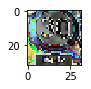

In [12]:
# load images and pre-process

image_directory = './examples'
downloaded_images = []
image_classes = []
for imfile in os.listdir(image_directory):
    if 'sign' in imfile:
        im = Image.open(os.path.join(image_directory,imfile))
        im_array = np.asarray(im)
        downloaded_images.append(im_array)
        im_class = int(imfile[7:9])
        image_classes.append(im_class)
        
X_downloaded = im_specific_normalize(np.array(downloaded_images))
y_downloaded = np.array(image_classes)

print("Loaded {0} downloaded images.".format(len(X_downloaded)))
print("Image size: {0}".format(X_downloaded[0].shape))

# display random image to check
index = random.randint(0, len(X_downloaded))
image = X_downloaded[index]
plt.figure(figsize=(1,1))
plt.imshow(image)
sign_index = y_downloaded[index]
print("Sign {0}: \"{1}\"".format(sign_index,sign_names[sign_index]))


In [13]:
# test model accuracy on downloaded images

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('mynet.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    download_accuracy = evaluate(X_downloaded,y_downloaded)
    print("Final model: Downloaded images accuracy = {:.3f}".format(download_accuracy))


Final model: Downloaded images accuracy = 0.900


In [14]:
# print out softmax probabilities for each image

def my_softmax(x):
    return 1. / (1 + np.exp(-x))

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('mynet.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))

    for i in range(len(X_downloaded)):
        x_im = X_downloaded[i:i+1]
        y_im = y_downloaded[i:i+1]
        top_5 = tf.nn.top_k(tf.nn.softmax(logits),k=5)
        output = sess.run(top_5, feed_dict={x:x_im, y:y_im, keep_prob:1.0})
        print("Sign {0}: {1} ({2})".format(i,y_downloaded[i],sign_names[y_downloaded[i]]))
        sm_vals = output.values[0]
        id_vals = output.indices[0]
        for i in range(len(sm_vals)):
            print("Softmax: {:0.3f} - ID {:2d} ({:40})".format(sm_vals[i],id_vals[i],sign_names[id_vals[i]]))
          

Sign 0: 11 (Right-of-way at the next intersection)
Softmax: 1.000 - ID 11 (Right-of-way at the next intersection   )
Softmax: 0.000 - ID 30 (Beware of ice/snow                      )
Softmax: 0.000 - ID 27 (Pedestrians                             )
Softmax: 0.000 - ID 21 (Double curve                            )
Softmax: 0.000 - ID 24 (Road narrows on the right               )
Sign 1: 14 (Stop)
Softmax: 1.000 - ID 14 (Stop                                    )
Softmax: 0.000 - ID 17 (No entry                                )
Softmax: 0.000 - ID 25 (Road work                               )
Softmax: 0.000 - ID  5 (Speed limit (80km/h)                    )
Softmax: 0.000 - ID  3 (Speed limit (60km/h)                    )
Sign 2: 14 (Stop)
Softmax: 1.000 - ID 14 (Stop                                    )
Softmax: 0.000 - ID 17 (No entry                                )
Softmax: 0.000 - ID 25 (Road work                               )
Softmax: 0.000 - ID 13 (Yield                          